## Introduction 
Cardiovascular diseases (CVDs) are the leading cause of death globally, taking an estimated 17.9 million lives each year [1]. CVDs are a group of disorders of the heart and blood vessels and include coronary heart disease, cerebrovascular disease, rheumatic heart disease and other conditions [1]. More than four out of five CVD deaths are due to heart attacks and strokes, and one third of these deaths occur prematurely in people under 70 years of age [2]. 

In this project, utilizing a database that captures key factors such as gender, age, blood glucose, and blood pressure of participants, we aim to develop a classification model to predict the likelihood of a new patient experiencing a heart attack.

By using a classification model, we would predict the presence of a heart attack based on the main predictors. The question we will be addressing is: **Is a new patient likely to have heart disease, based on age, troponin and kcm?**
 

## Methods
Since the variable “class”, which depicts the presence of a heart attack, is a categorical variable, we choose to conduct our data analysis by classification, specifically by using K nearest neighbors classification algorithm.

To help visualize our results and our predictions, we can plot a scatter plot to help determine what factors contribute to the presence of a heart attack as will be seen in Figure 1 and Figure 2. We will base our predictions on known indicators/predictors such as age, troponin levels and kcm - enzyme amount, because, in our preliminary analysis, these variables showed differences in mean the most in positive and negative classes.

Each column is numeric-valued and there are 1316 rows in the clean data, with no missing data represented. To tidy the dataset, we renamed columns so that they're grammatically correct and understandable for reader without medical background(i.e. kcm renamed to enzyme_amount). Also, we filtered the impulse (i.e. heartbeat) column to appropriate values to less than or equal to 200 [3].To summarize the heart attack dataset, we grouped by class then summarized for mean of each column. We noticed that the mean age of patients with heart attack is higher, as well as their kcm, troponin.

The columns we will be using are as follows:

1. **age**: age of the patients 
7. **kcm**: amount of specific enzymes(CK-MB) - renamed to **enzyme_amount**
8. **troponin**: Test-Troponin in (ng/L [4])
9. **class**: diagnosis type - negative refers to the absence of a heart attack, while positive refers to the presence of a heart attack.

We do KNN-classification analysis for 3 models: the first model (age,troponin) and the second (age, enzyme_amount) leverage two predictors, while third model (age,troponin and enzyme_amount) uses all three. We performed data preprocessing, splitting the data to train/test, standardizing the data, creating the KNN model and the recipe with specified predictors, compiling a workflow to fit, and predicting the diagnosis class. Also, to evaluate the accuracy and tune the classifier, we leverage cross-validation to select the optimal value of K. As we pick the most optimal K value from cross-validation, we retrain the classifier with the chosen final K. Lastly, we analyse and compare the estimated accuracy of the classifier on the test set for all models, with the help of calculated accuracies as well as a confusion matrix.

To proceed with our project in R and Jupyter Notebook, we loaded the necessary packages/libraries, as seen below, to use the necessary functions. To make our data reproducible, we set the seed. To read the dataset from the web, we uploaded to Github manually and loaded to the notebook using *read_csv(url)*. We used initial_split() to split our dataframe into 75% training and 25% testing data, stratifying for class. To clean our data, we select only the relevant variables, *age, enzyme_amount, troponin, and class*, and mutate **class** into a factor.

### Preliminary exploratory data analysis

In [6]:
library(tidyverse)
library(repr)
library(tidymodels)
library(GGally)
library(ISLR)
options(repr.matrix.max.rows = 6)

Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2



### Loading data from the web

In [3]:
url = "https://raw.githubusercontent.com/l-glucose/dsci100/main/data/heart_attack.csv"
raw_data <- read_csv(url, show_col_types = FALSE)
raw_data

age,gender,impluse,pressurehight,pressurelow,glucose,kcm,troponin,class
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
64,1,66,160,83,160,1.80,0.012,negative
21,1,94,98,46,296,6.75,1.060,positive
55,1,64,160,77,270,1.99,0.003,negative
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
45,1,85,168,104,96,1.24,4.250,positive
54,1,58,117,68,443,5.80,0.359,positive
51,1,94,157,79,134,50.89,1.770,positive


In [22]:
options(repr.plot.height = 15, repr.plot.width = 15)
pairplot <- raw_data |> 
    ggpairs(
        lower = list(continuous = wrap('points', alpha = 0.4)),
        diag = list(continuous = "barDiag")
    ) +
    theme(text = element_text(size = 10))
pairplot
options(repr.plot.height = 7, repr.plot.width = 8)


ERROR: Error in eval(expr, envir, enclos): object 'raw_data' not found


In [15]:
# focus on the class column and discuss the trends/destributions of each parameter, explain why we select age, kcm and troponin for the model(the summaries are similiar/lack of distinctiveness for other factors such as impluse, bp, etc.)

#### Table 1. Sample of dataset with the chosen predictors

In [16]:
# Mutating the target column "class" to be a factor
data <- raw_data |> mutate(class = as_factor(class))

# Tidying the data by renaming columns and removing NA values
data_tidy <- data |>
  rename(
    pressure_high = pressurehight,
    pressure_low = pressurelow,
    impulse = impluse,
    enzyme_amount = kcm) |> filter(impulse <= 200) |> drop_na() 


# Selecting the nessesary columns 
trial <- select(data_tidy, age, troponin, enzyme_amount, class)

trial |> head(5)

ERROR: Error in eval(expr, envir, enclos): object 'raw_data' not found


The table above shows first 5 rows from the dataset with selected columns *(age, troponin, enzyme_amount, target class)*

In [17]:
set.seed(1000)
trial_split <- initial_split(trial, prop = 0.75, strata = class)
trial_train <- training(trial_split)
trial_test <- testing(trial_split) 

In [ ]:
# need descriptions here for initial spliting

In [18]:
trial_proportions <- trial_train |>
                      group_by(class) |>
                      summarize(n = n()) |>
                      mutate(percent = 100*n/nrow(trial_train))
trial_proportions

class,n,percent
<fct>,<int>,<dbl>
negative,381,38.60182
positive,606,61.39818


In [ ]:
# We might remove the above cell since it's not very useful, otherwise please justify why we need this table

In [194]:
mean_statistics <- trial_train |>
              group_by(class) |>
              summarize(mean_age = mean(age), mean_troponin= mean(troponin),mean_enzyme=mean(enzyme_amount))

mean_statistics

class,mean_age,mean_troponin,mean_enzyme
<fct>,<dbl>,<dbl>,<dbl>
negative,52.25197,0.00660105,2.516367
positive,58.98350,0.57337459,24.294477


In [ ]:
# explain here how the difference of means can used for classification model

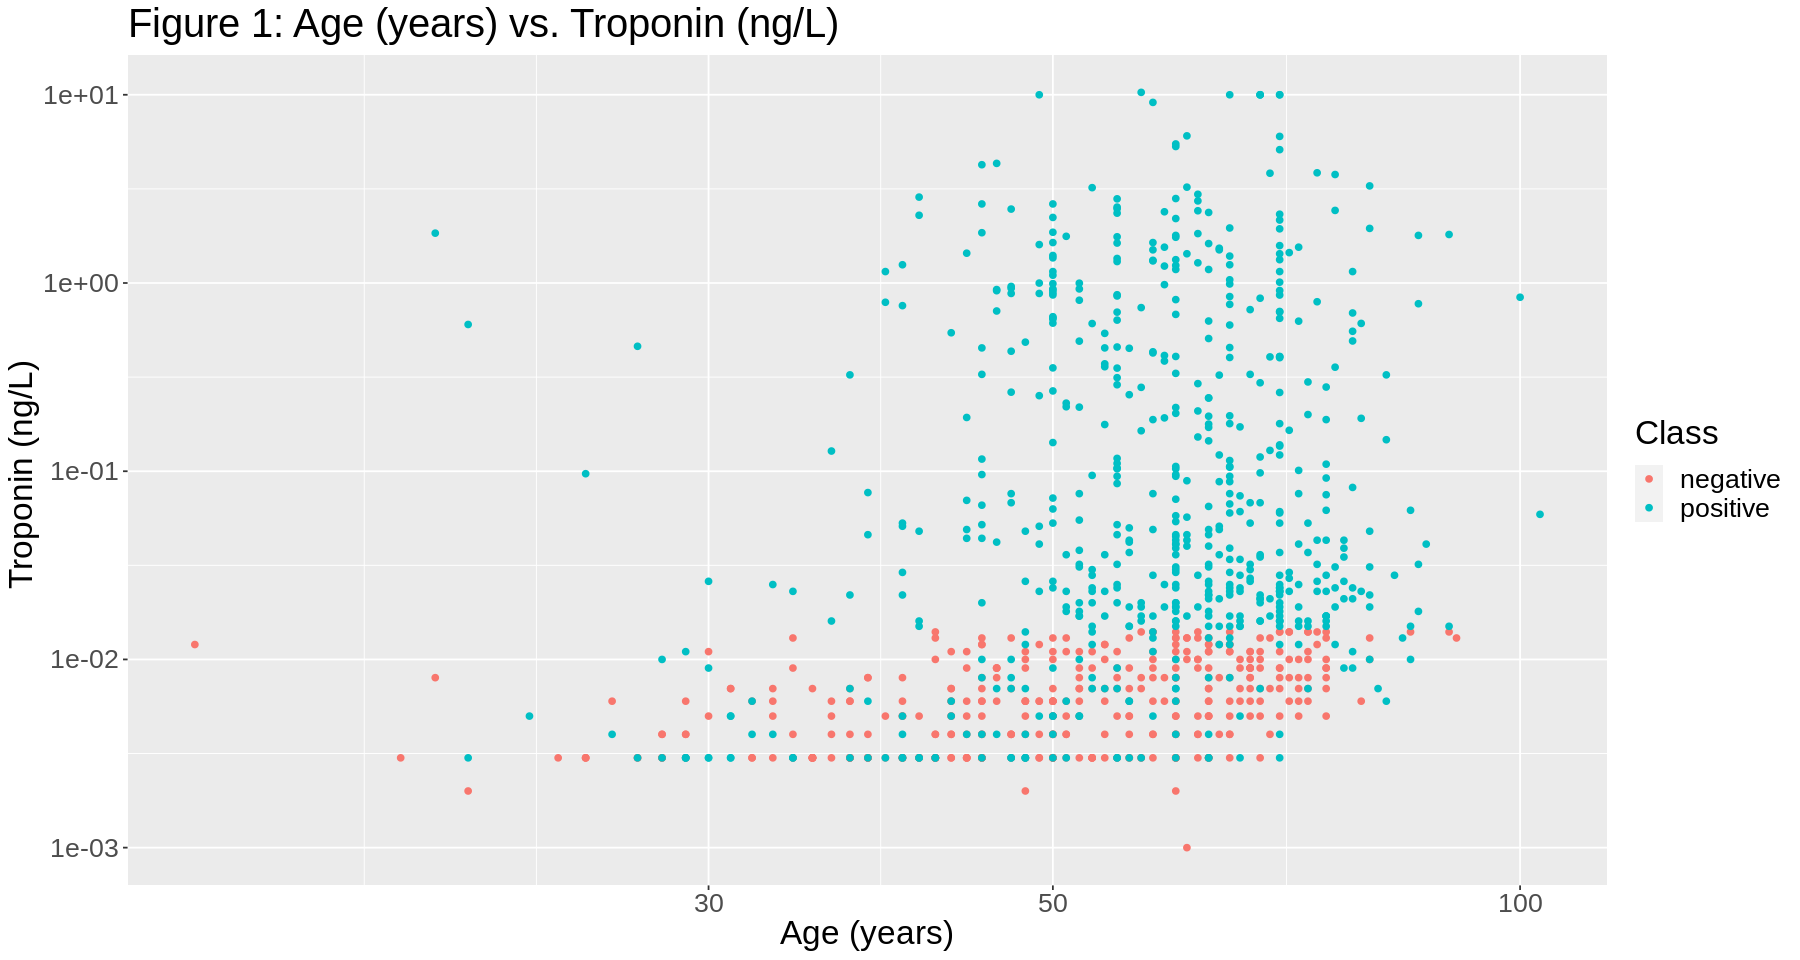

In [195]:
options(repr.plot.width=15, repr.plot.height=8)
age_troponin_chart <- trial_train |>
                           ggplot(aes(x=age, y=troponin, color=class)) + 
                           geom_point() + ggtitle("Figure 1: Age (years) vs. Troponin (ng/L)") + 
                           labs(x="Age (years)", y="Troponin (ng/L) ", color="Class") + scale_x_log10() + scale_y_log10() + theme(text = element_text(size = 20))

age_troponin_chart

##### Figure 1 - Age(years) on the x-axis and Troponin(ng/L) on the y-axis and points of the chart are colored based on the Class factor. From the chart above, we see that there is a separation between 2 categories of classes (positive and negative), therefore we conclude that these parameters are suitable to train the classifier on them.

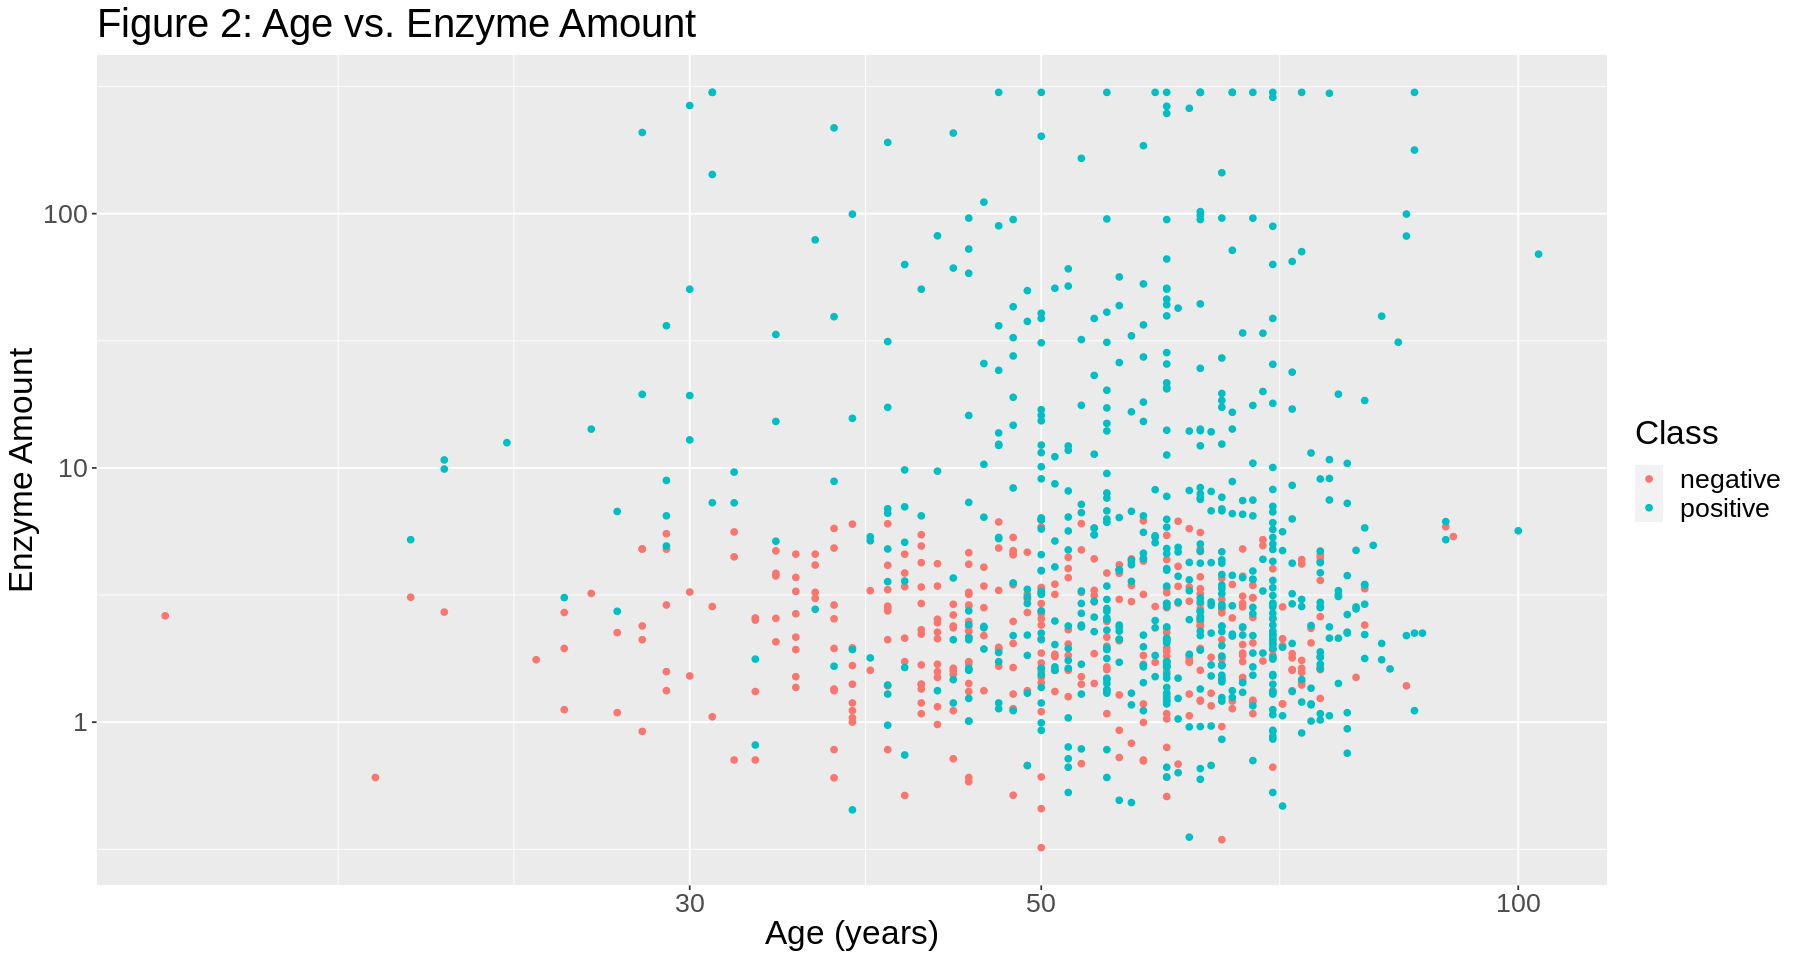

In [196]:
options(repr.plot.width=15, repr.plot.height=8)
age_kcm_chart <- trial_train |>
                           ggplot(aes(x=age, y=enzyme_amount, color=class)) + 
                           geom_point() + ggtitle("Figure 2: Age vs. Enzyme Level") + 
                           labs(x="Age (years)", y="Enzyme Level", color="Class") + scale_x_log10() + scale_y_log10() + theme(text = element_text(size = 20))

age_kcm_chart

#### Figure 2 - Age on the x-axis and KCM Enzyme on the y-axis and points of the chart are colored based on the Class factor. From the chart above, we see that there is a separation between 2 categories of classes (positive and negative), thus we conclude that these parameters are suitable to train the classifier on them.

### Model 1: KNN classification (2 parameters: age and troponin)

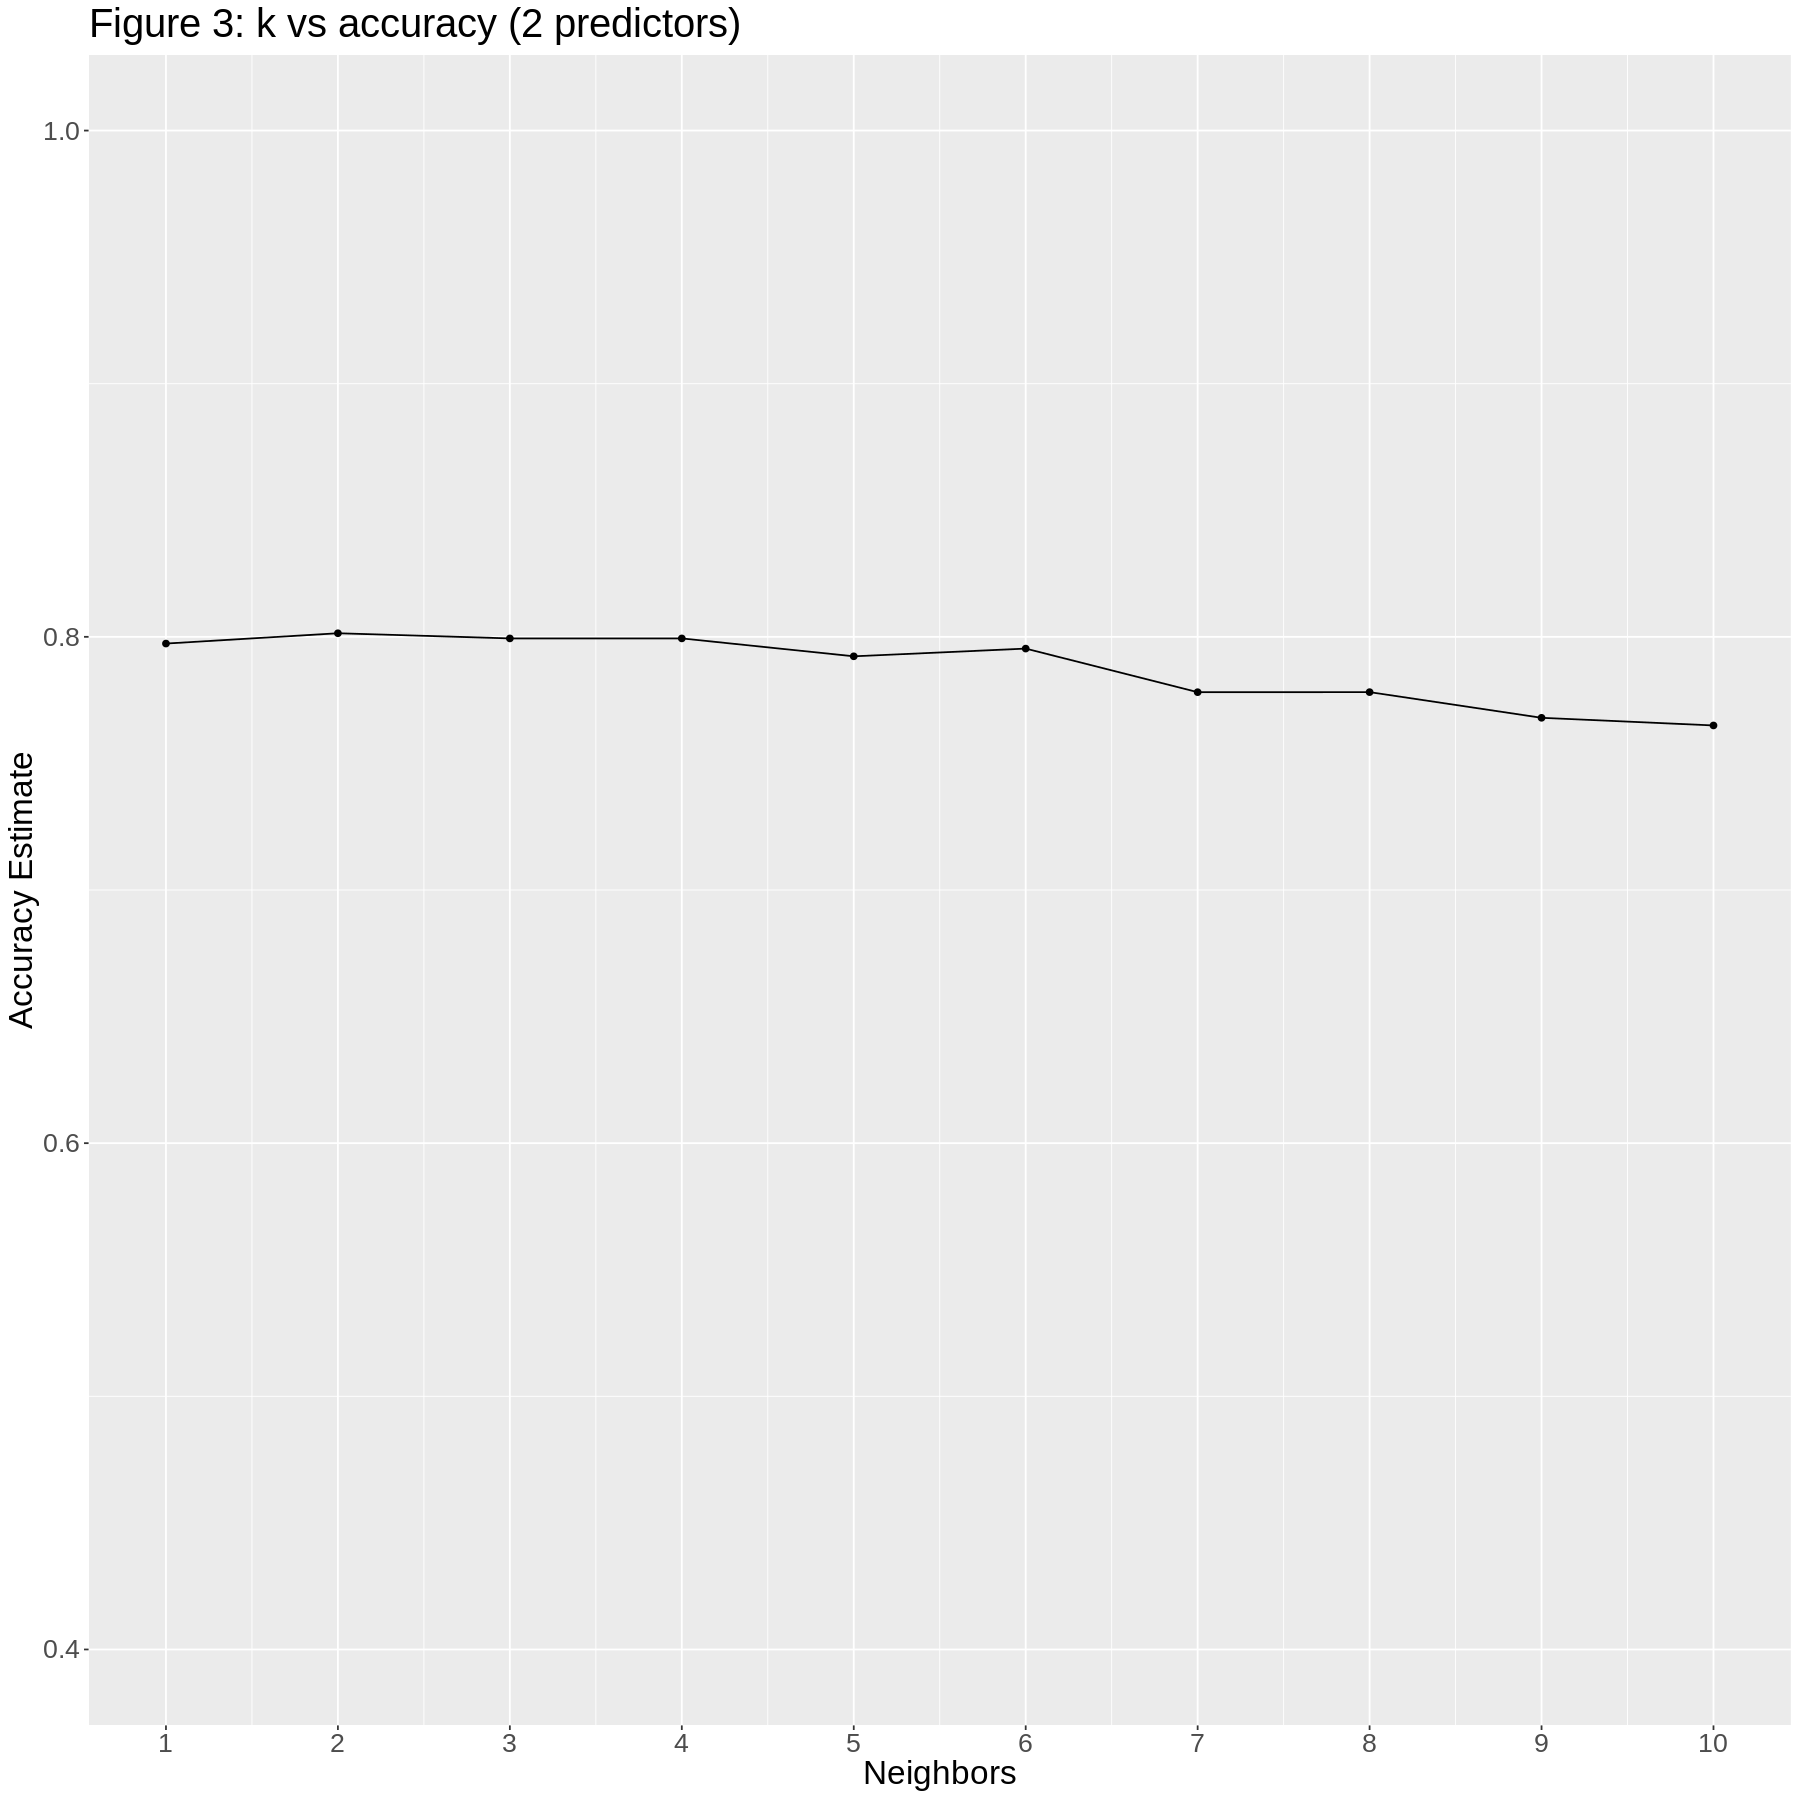

In [39]:
set.seed(1000)
trial_recipe_troponin <- recipe(class ~ age + troponin, data = trial_train) |>
                step_scale(all_predictors()) |>
                step_center(all_predictors())
                

knn_spec_tune <- nearest_neighbor(weight_func="rectangular", neighbors=tune()) |>
            set_engine("kknn") |>
            set_mode("classification")

trial_vfold <- vfold_cv(trial_train, v=5, strata=class)

k_vals <- tibble(neighbors=seq(from=1, to=10, by=1))

trial_workflow <- workflow() |>
                  add_recipe(trial_recipe_troponin) |>
                  add_model(knn_spec_tune) |>
                  tune_grid(resamples=trial_vfold, grid=k_vals) |>
                  collect_metrics()

model_1_accuracies <- trial_workflow |> 
      filter(.metric=='accuracy')
model_2_cross_val_plot <- ggplot(accuracies, aes(x = neighbors, y = mean))+
      geom_point() +
      geom_line() +
      labs(x = "Neighbors", y = "Accuracy Estimate") +
      ggtitle("Figure 3: k vs accuracy (2 predictors)") + 
      scale_x_continuous(breaks = seq(0, 10, by = 1)) +
      scale_y_continuous(limits = c(0.4, 1.0)) + theme(text = element_text(size = 20))

model_2_cross_val_plot

The code above uses 5-fold cross-validation with neighbors from 1 to 10 to train the KNN classification algorithm to predict the class using age and troponin. Figure 3 displays the accuracy on the y-axis and the number of neighbors on the x-axis. Since the accuracy stays almost equal after k=6, we choose k=6 as the final number of neighbors.

In [40]:
k_model_1 <- 6

knn_spec <- nearest_neighbor(weight_func="rectangular", neighbors=k_model_1) |>
            set_engine("kknn") |>
            set_mode("classification")

model_1_fit <- workflow() |>
              add_recipe(trial_recipe_troponin) |>
              add_model(knn_spec) |>
              fit(data = trial_train)

model_1_predictions <- predict(model_1_fit , trial_test) |>
      bind_cols(trial_test)

In [41]:
model_1_accuracy <- model_1_predictions |>
                            metrics(truth = class, estimate = .pred_class)    
model_1_accuracy

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.7872340
kap,binary,0.5782669


In [44]:
# need explainations of accuracy and confused matrix (for all three models)

In [45]:
model_1_conf_mat <- trial_predictions |>
                             conf_mat(truth = class, estimate = .pred_class)

model_1_conf_mat

          Truth
Prediction negative positive
  negative      114       57
  positive       13      145

### Model 2: KNN classification (2 parameters: age and enzymes)

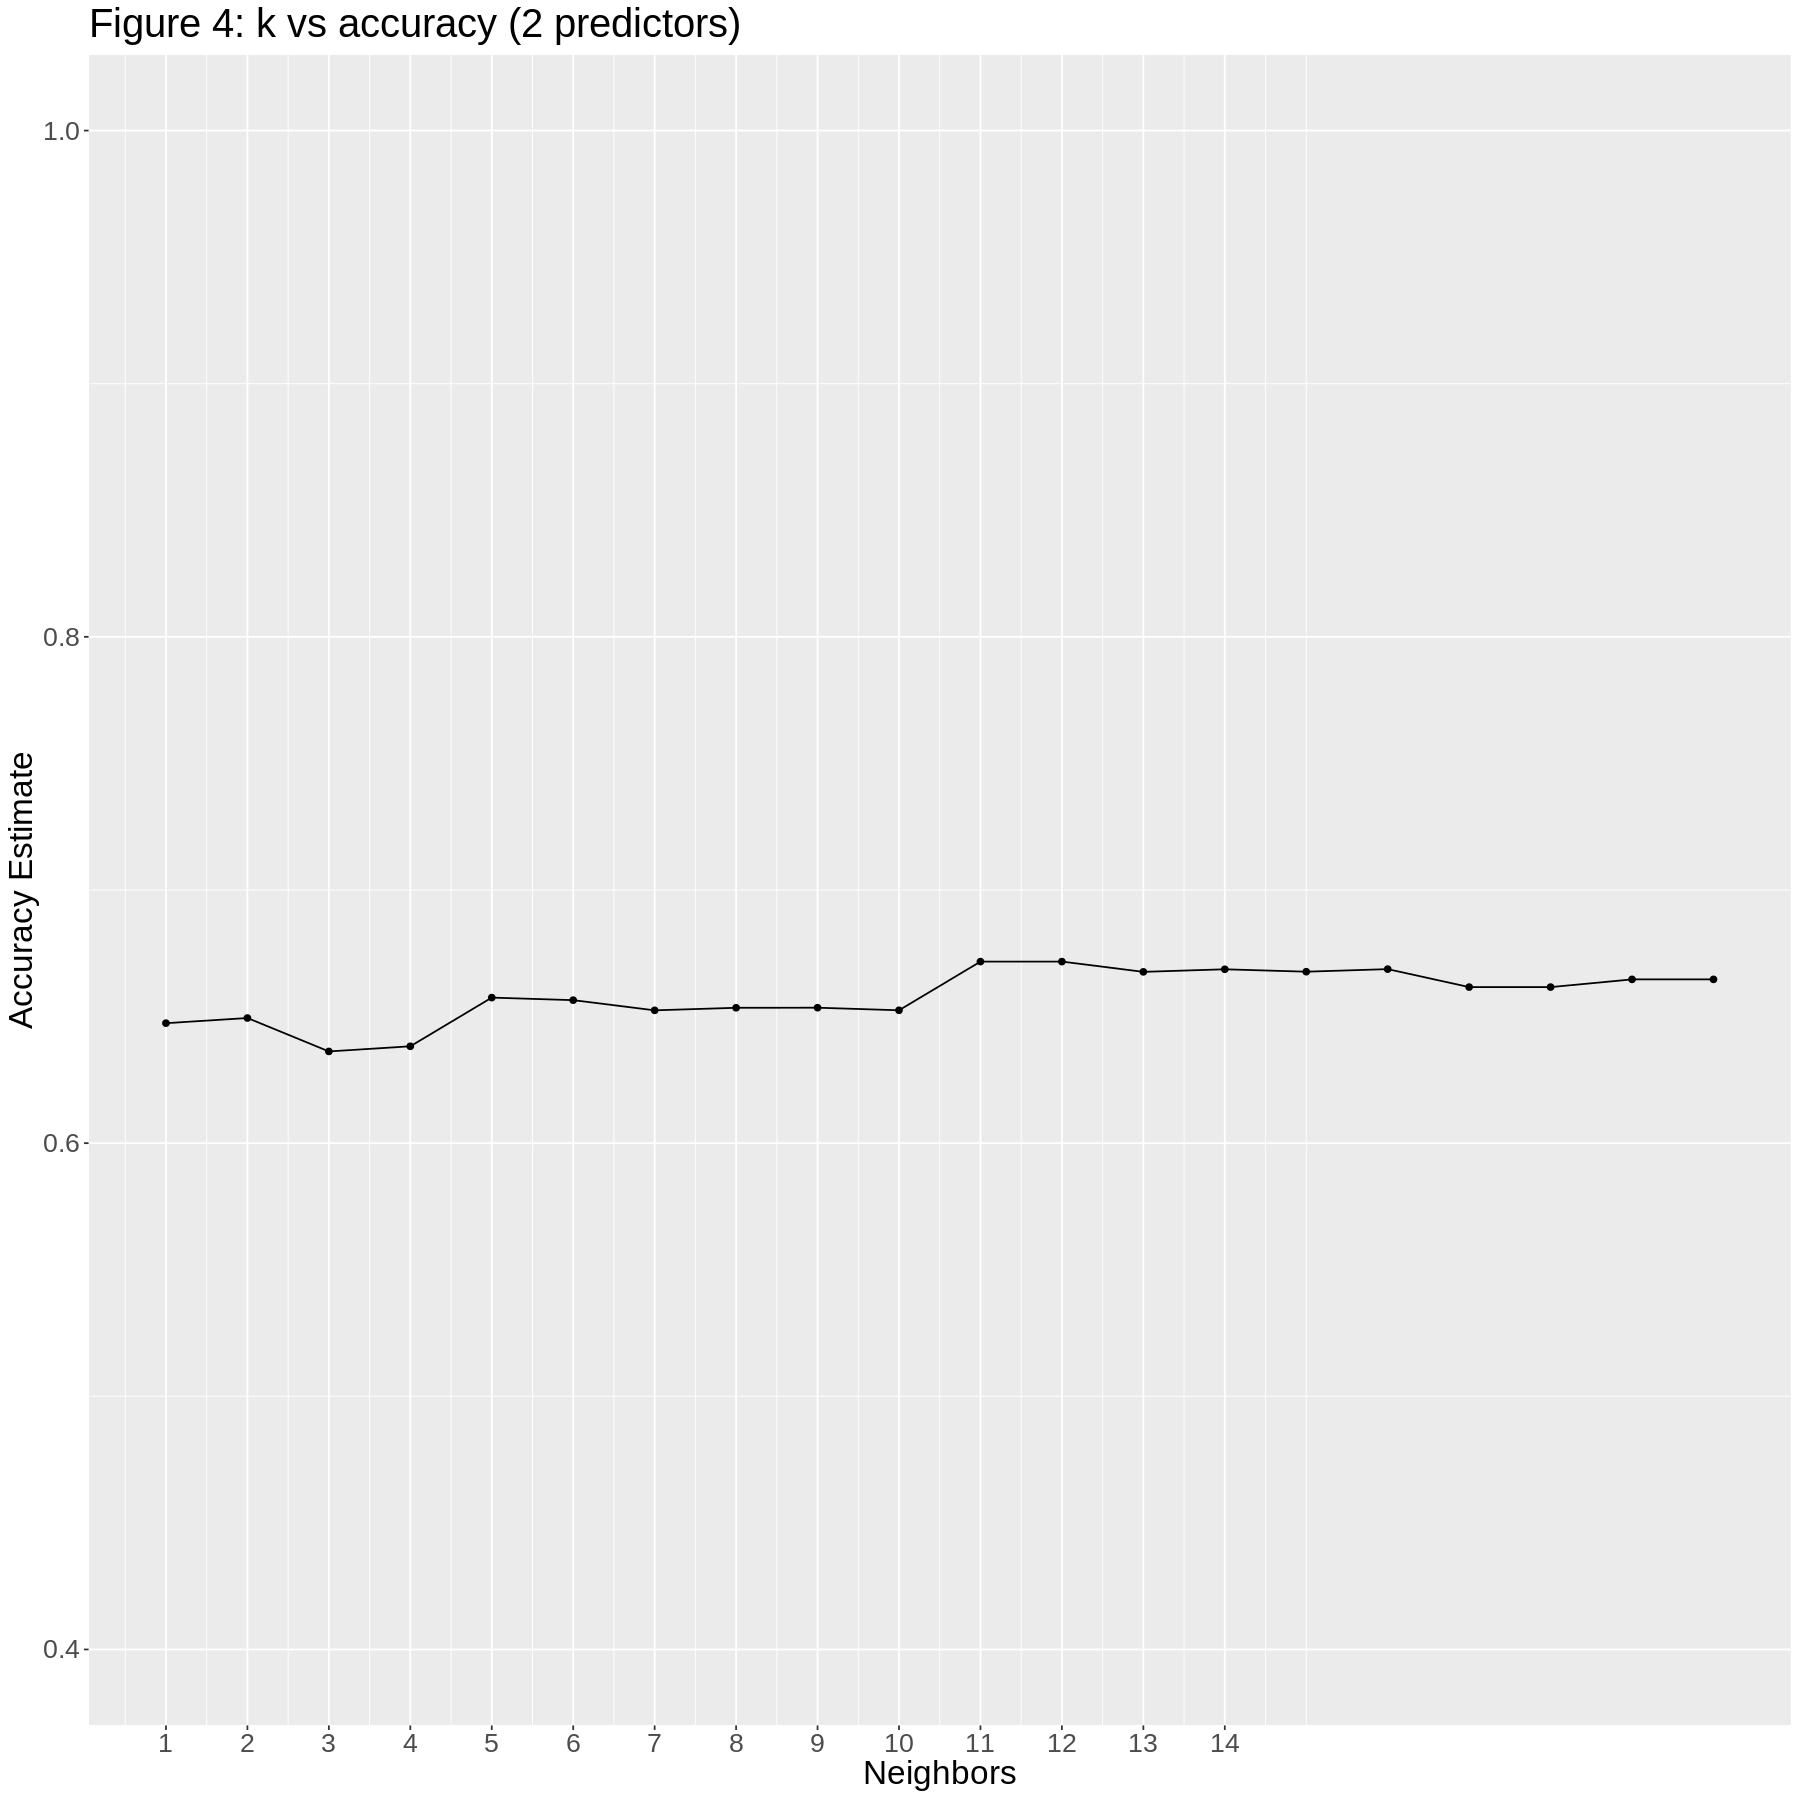

In [46]:
set.seed(1000)
model_2_recipe <- recipe(class ~ age + enzyme_amount, data = trial_train) |>
                step_scale(all_predictors()) |>
                step_center(all_predictors())
                
trial_vfold <- vfold_cv(trial_train, v=5, strata=class)

k_vals <- tibble(neighbors=seq(from=1, to=20, by=1))

trial_workflow <- workflow() |>
                  add_recipe(model_2_recipe) |>
                  add_model(knn_spec_tune) |>
                  tune_grid(resamples=trial_vfold, grid=k_vals) |>
                  collect_metrics()

model_2_accuracies <- trial_workflow |> 
      filter(.metric=='accuracy')

model_2_cross_val_plot <- ggplot(model_2_accuracies, aes(x = neighbors, y = mean))+
      geom_point() +
      geom_line() +
      labs(x = "Neighbors", y = "Accuracy Estimate") +
      ggtitle("Figure 4: k vs accuracy (2 predictors)") + 
      scale_x_continuous(breaks = seq(0, 14, by = 1)) +
      scale_y_continuous(limits = c(0.4, 1.0)) + theme(text = element_text(size = 20))

model_2_cross_val_plot

The code above uses 5-fold cross-validation with neighbors from 1 to 10 to train the KNN classification algorithm to predict the class using age and troponin. Figure 4 displays the accuracy on the y-axis and the number of neighbors on the x-axis. Since the accuracy stays almost equal and greater than others after k=11, we choose k=11 as the final number of neighbors.

In [48]:
model_2_k <- 11

model_2_knn_spec <- nearest_neighbor(weight_func="rectangular", neighbors=model_2_k) |>
            set_engine("kknn") |>
            set_mode("classification")

model_2_fit <- workflow() |>
              add_recipe(model_2_recipe) |>
              add_model(model_2_knn_spec) |>
              fit(data = trial_train)

model_2_predictions <- predict(model_2_fit , trial_test) |>
      bind_cols(trial_test)

In [49]:
trial_prediction_accuracy <- model_2_predictions |>
                            metrics(truth = class, estimate = .pred_class)    
trial_prediction_accuracy

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.6686930
kap,binary,0.2832531


### Model 3: KNN classification (3 parameters: age, enzyme and troponin)

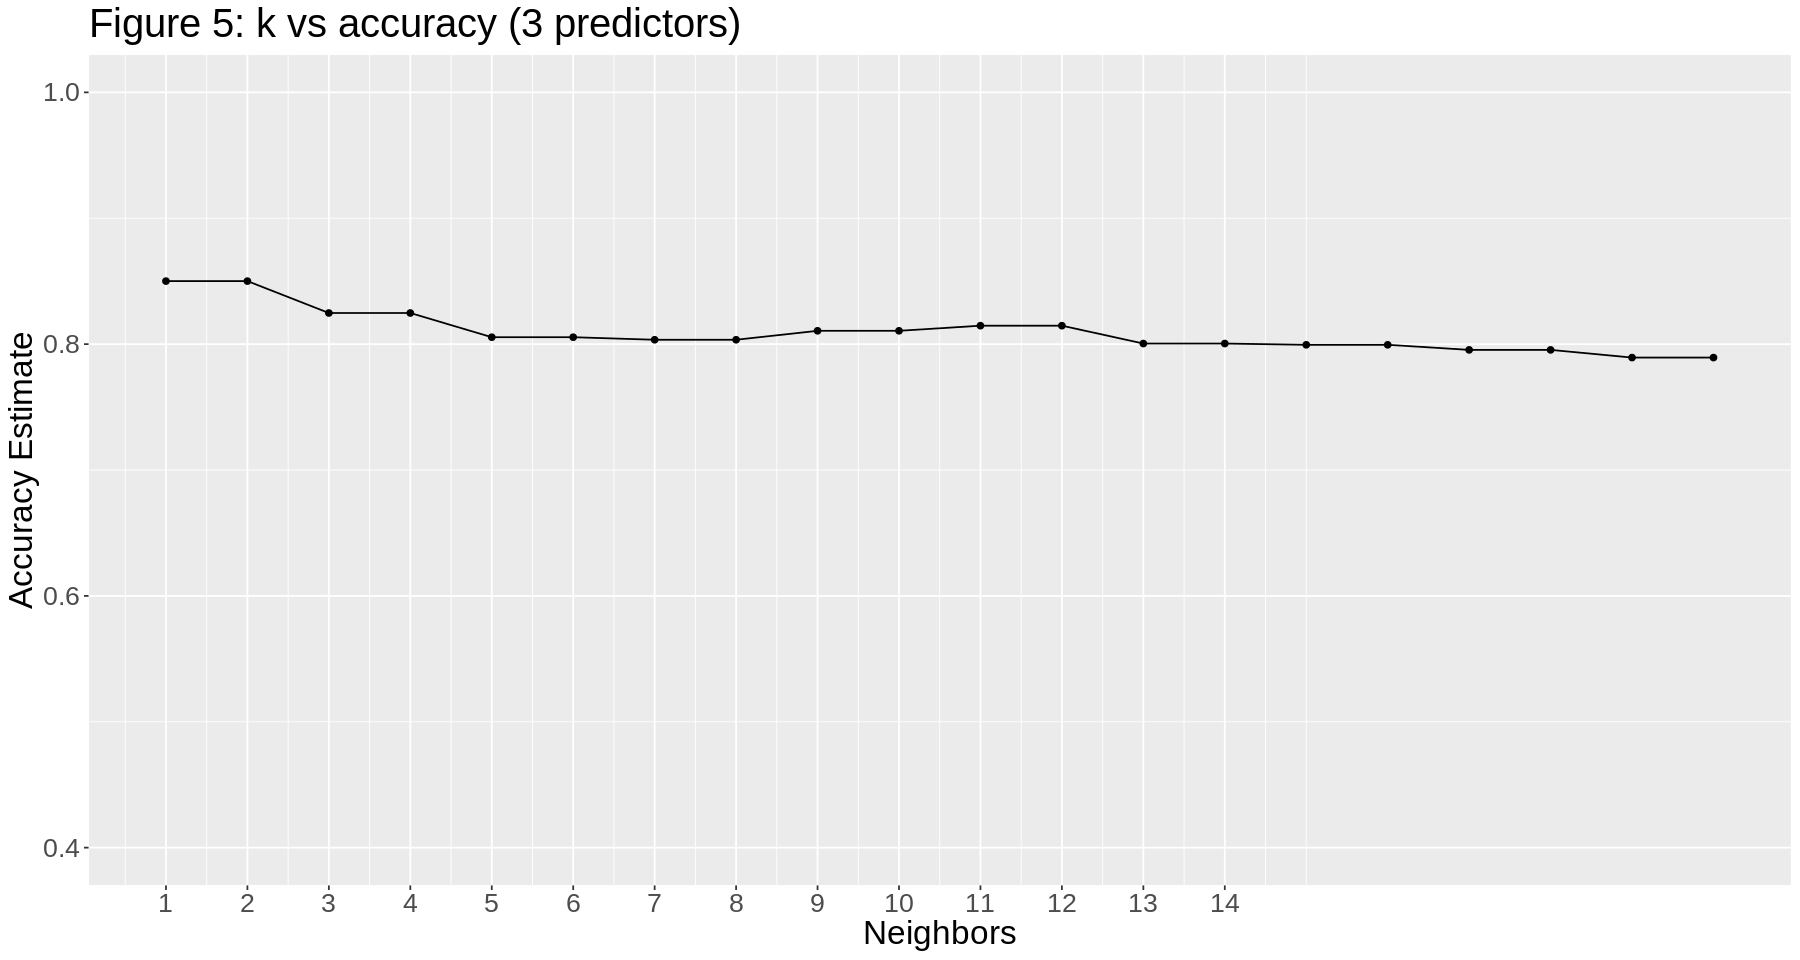

In [210]:
set.seed(1000)
trial_recipe <- recipe(class ~ age+troponin+enzyme_amount, data = trial_train) |>
                step_scale(all_predictors()) |>
                step_center(all_predictors())
                

knn_spec <- nearest_neighbor(weight_func="rectangular", neighbors=tune()) |>
            set_engine("kknn") |>
            set_mode("classification")

trial_vfold <- vfold_cv(trial_train, v=5, strata=class)

k_vals <- tibble(neighbors=seq(from=1, to=20, by=1))

trial_workflow <- workflow() |>
                  add_recipe(trial_recipe) |>
                  add_model(knn_spec) |>
                  tune_grid(resamples=trial_vfold, grid=k_vals) |>
                  collect_metrics()

accuracies <- trial_workflow |> 
      filter(.metric=='accuracy')

cross_val_plot <- ggplot(accuracies, aes(x = neighbors, y = mean))+
      geom_point() +
      geom_line() +
      labs(x = "Neighbors", y = "Accuracy Estimate") +
      ggtitle("Figure 5: k vs accuracy (3 predictors)") + 
      scale_x_continuous(breaks = seq(0, 14, by = 1)) +
      scale_y_continuous(limits = c(0.4, 1.0)) + theme(text = element_text(size = 20))

cross_val_plot

The code above uses 5-fold cross-validation with neighbors from 1 to 10 to train the KNN classification algorithm to predict the class using age and troponin. Figure 5 displays the accuracy on the y-axis and the number of neighbors on the x-axis. Since the accuracy stays almost equal after and greater than others at k=10, we choose k=10 as the final number of neighbors.

In [215]:
k_final <- 10

knn_spec <- nearest_neighbor(weight_func="rectangular", neighbors=k_final) |>
            set_engine("kknn") |>
            set_mode("classification")

trial_fit <- workflow() |>
              add_recipe(trial_recipe) |>
              add_model(knn_spec) |>
              fit(data = trial_train)

trial_predictions <- predict(trial_fit , trial_test) |>
      bind_cols(trial_test)

In [216]:
trial_prediction_accuracy <- trial_predictions |>
                            metrics(truth = class, estimate = .pred_class)    
trial_prediction_accuracy

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.8206687
kap,binary,0.6380773


In [217]:
trial_prediction_conf_mat <- trial_predictions |>
                             conf_mat(truth = class, estimate = .pred_class)

trial_prediction_conf_mat

          Truth
Prediction negative positive
  negative      113       45
  positive       14      157

### Results
Model 1: *age, troponin* (2 parameters)  
For our K value, we select 6. In our first model, the accuracy of our model is 78.7%. It is still questionable if this might be the right model.

Model 2: *age, enzyme_amount* (2 parameters)  
For our K value, we select 11. In our second model, the accuracy of our model is 66.9%. This model gives lower accuracy than previous one, so we immediately assume it is not the right fit.

Model 3: *age, enzyme_amount, troponin* (3 parameters)  
For our K value, we select 7. In our third model, the accuracy of our model is 82.0%. This seems like a good model for predicting the testing data. 


### Discussion (To be edited)

**Answering the Predictive Question:**

**Summary of Results:** 
Desribe the visualizations ()
less effect on  class factor
Which variable/column has the most /least impact
use figures to refer to

**Model 1:**  describe the process performed and dscribe confusion matrix --> conclude with accuracy achieved
**Model 2:** 

**Impact of Results:** 
application to the real world,how applied in medicine? how efficient the models are? reliable? 

KNN classification - advantage and disadvantage in this analysis


**Further Projects Based on Results:** 

how to extend? any limitations we had( sample size?server and computational power? -- how to solve ? what hardware to use for better results)
Our project leads to the following future questions: 

### Bibliography 
-  [1] https://www.who.int/health-topics/cardiovascular-diseases
-  [2] https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6011508/
-  [3] https://www.mayoclinic.org/healthy-lifestyle/fitness/expert-answers/heart-rate/faq-20057979#:~:text=A%20normal%20resting%20heart%20rate%20for%20adults%20ranges%20from%2060,function%20and%20better%20cardiovascular%20fitness.